In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
csv_path = '..\data\_approach_1.csv'
df = pd.read_csv(csv_path)
df.head()

,time_stamp,date_time,volume_per_hour,speed_kmh,travel_time,free_flow_travel_time,usual_delay_sec,delay_sec
0,1576796430000,20/12/2019 00:01:00,388,12.250033,61,35,-1,26
1,1576796490000,20/12/2019 00:02:00,388,14.652000,51,35,-1,16
2,1576796550001,20/12/2019 00:03:00,388,13.586401,55,35,-1,20
3,1576796610000,20/12/2019 00:04:00,388,13.586401,55,35,-1,20
4,1576796670000,20/12/2019 00:05:00,388,13.586401,55,35,-1,20


In [3]:
df.volume_per_hour = df.loc[:,"volume_per_hour"].replace(to_replace=0, method='ffill')
df.speed_kmh = df.loc[:,"speed_kmh"].replace(to_replace=0, method='ffill')
df.travel_time = df.loc[:,"travel_time"].replace(to_replace=0, method='ffill')
df.loc[df.volume_per_hour > 1800, "volume_per_hour"] = 1800

In [4]:
def aggregate_df_each_five_min(df, begin_time_stamp):
    mean_vol = df.volume_per_hour.mean()
    mean_speed = df.speed_kmh.mean()
    mean_travel_time = df.travel_time.mean()
    five_min_speed_aggr = []
    five_min_vol_aggr = []
    five_min_tt_aggr = []

    date_list = []
    timestamp_list = []
    for i in range(df.shape[0] // 5):
        five_min_result = df.loc[
            (df.time_stamp >= begin_time_stamp) & (df.time_stamp <= begin_time_stamp + 300000)]
        five_min_count = five_min_result.shape[0]
        timestamp_list.append(begin_time_stamp + 300000)
        if five_min_count > 0:
            five_min_vol_aggr.append(five_min_result.volume_per_hour.mean())
            five_min_speed_aggr.append(five_min_result.speed_kmh.mean())
            five_min_tt_aggr.append(five_min_result.travel_time.mean())
            date_list.append(five_min_result.iloc[five_min_count - 1].date_time)
        else:
            five_min_vol_aggr.append(mean_vol)
            five_min_speed_aggr.append(mean_speed)
            five_min_tt_aggr.append(mean_travel_time) 

        begin_time_stamp = begin_time_stamp + 300000

    return timestamp_list, date_list, five_min_vol_aggr, five_min_speed_aggr, five_min_tt_aggr

In [5]:
start_timestamp = 1576796429000
five_min_tuples = aggregate_df_each_five_min(df, start_timestamp)

In [6]:
label_path = '..\data\MeasuremetStations30050.rpt'
measures = pd.read_fwf(label_path, skiprows=[1], nrows=22285)
measures.loc[:,"Vehicles"].replace(to_replace=0, method='ffill')
measures.loc[measures["Vehicles"] > 1800 , ["Vehicles"]] =  1800

labels = measures["Vehicles"]
labels = labels * 12
labels.index = measures["MeasurementStationID Timestamp"]


In [7]:
aggr_tuples = list(zip(five_min_tuples[0], five_min_tuples[1], five_min_tuples[2], five_min_tuples[3],
                       five_min_tuples[4], labels))
    
aggr_df = pd.DataFrame(aggr_tuples,
                           columns=["timestamp", "date", "volume_per_hour", "speed_kmh", "travel_time", "vehicle_count"])

In [8]:
aggr_df.shape

(19189, 6)

per_five_min  = df.iloc[lambda x: x.index % 5 == 4]
dates = per_five_min[["time_stamp", "date_time"]]

//df = df.groupby(np.arange(len(df))//5).mean()

In [9]:
features_considered = ['volume_per_hour', 'speed_kmh', 'travel_time', 'vehicle_count']
features = aggr_df[features_considered]
features.index = aggr_df['date']
features.head()


,volume_per_hour,speed_kmh,travel_time,vehicle_count
date,,,,
20/12/2019 00:05:00,388.0,13.532247,55.4,528
20/12/2019 00:10:00,601.4,15.737581,47.8,432
20/12/2019 00:15:00,737.2,16.932894,44.2,504
20/12/2019 00:20:00,950.6,17.629972,42.4,444
20/12/2019 00:25:00,698.4,16.101206,46.6,432


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000014D49FC9148>,
      dtype=object)

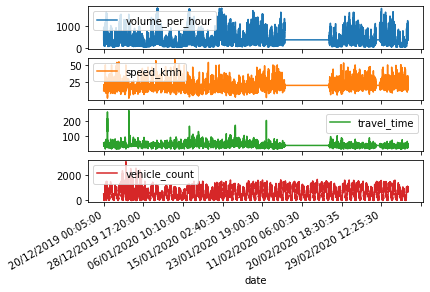

In [10]:
features.plot(subplots=True)

In [11]:
TRAIN_SPLIT = 16000

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [12]:
def get_labeled_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [13]:
tf.random.set_seed(13)
history_range = 288
target_range = 1
STEP = 1

x_train_single, y_train_single = get_labeled_data(dataset, dataset[:,3], 0,
                                                   TRAIN_SPLIT, history_range,
                                                   target_range, STEP,
                                                   single_step=True)
x_val_single, y_val_single = get_labeled_data(dataset, dataset[:,3],
                                               TRAIN_SPLIT, None, history_range,
                                               target_range, STEP,
                                               single_step=True)

In [14]:
print ('Single window of past history')
print (x_train_single[0])
print ('\n Target to predict')
print (y_train_single[0])


Single window of past history
[[ 0.0591903  -1.39563437  1.15296979 -0.09359784]
 [ 0.81977488 -0.93229685  0.57075576 -0.31665316]
 [ 1.30378325 -0.68116341  0.29497016 -0.14936167]
 ...
 [-0.2480374   1.39423861 -0.94606501 -0.12147976]
 [-0.51748535  1.94808776 -1.14524349 -0.42818082]
 [-0.8938571   2.36876801 -1.26781487 -0.26088933]]

 Target to predict
-0.31665316131195437
all history: (15712, 288, 4)


In [15]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [16]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mse', metrics=['acc'])
single_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4736      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [17]:
x_train_single.shape[-2:]

(288, 4)

In [18]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [ ]:
EVALUATION_INTERVAL = 500
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch = EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 500 steps, validate for 50 steps
Epoch 1/10
500/500 [==============================] - 195s 390ms/step - loss: 0.1483 - acc: 0.0000e+00 - val_loss: 0.0726 - val_acc: 0.0000e+00
Epoch 2/10
500/500 [==============================] - 196s 392ms/step - loss: 0.1233 - acc: 0.0000e+00 - val_loss: 0.0629 - val_acc: 0.0000e+00
Epoch 3/10
322/500 [==================>...........] - ETA: 1:10 - loss: 0.1206 - acc: 0.0000e+00

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [ ]:
for x, y in val_data_single.take(5):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()